# Preparing Environment

In [ ]:
%matplotlib inline
%tensorflow_version 1.x

# Importing libraries
import os
import pickle
import warnings
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import keras
import matplotlib.pyplot as plt
import json
import seaborn as sns

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from datetime import datetime
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, GaussianNoise, concatenate, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import get_file, to_categorical, plot_model, print_summary
from keras import backend as K
from keras import regularizers
from keras import losses
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from joblib import dump, load
from google.colab import drive

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# If using google colab
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "./drive/My Drive/Dataset/xPLNet.zip" "/content"
!unzip /content/xPLNet.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/Training Samples/8/18758.png  
 extracting: DATASET/Training Samples/8/18764.png  
 extracting: DATASET/Training Samples/8/18780.png  
 extracting: DATASET/Training Samples/8/18787.png  
 extracting: DATASET/Training Samples/8/18809.png  
 extracting: DATASET/Training Samples/8/18814.png  
 extracting: DATASET/Training Samples/8/18840.png  
 extracting: DATASET/Training Samples/8/18853.png  
 extracting: DATASET/Training Samples/8/18863.png  
 extracting: DATASET/Training Samples/8/18875.png  
 extracting: DATASET/Training Samples/8/18876.png  
 extracting: DATASET/Training Samples/8/1889.png  
 extracting: DATASET/Training Samples/8/18895.png  
 extracting: DATASET/Training Samples/8/18909.png  
 extracting: DATASET/Training Samples/8/18910.png  
 extracting: DATASET/Training Samples/8/18924.png  
 extracting: DATASET/Training Samples/8/18936.png  
 extracting: DATASET/Training Samples/8/18937.png  
 extracting: D

In [ ]:
data_dir = "/content/DATASET"
data_dir

'/content/DATASET'

In [ ]:
!nvidia-smi

Tue Apr 21 16:59:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Dataset Preparation

In [ ]:
with h5py.File("./drive/My Drive/Dataset/soybean_leaf.h5", 'r') as hf:
  x_train = np.asarray(hf["Training Samples"])
  x_test = np.asarray(hf["Test Samples"])

In [ ]:
labels = [i for i in range(0, 9, 1)]
train_dir = data_dir + "/Training Samples"
train_data_dist = []

for i in range(0, 9, 1):
    print(f"{labels[i]} {len(os.listdir(os.path.join(train_dir, str(i))))} images")
    train_data_dist.append(len(os.listdir(os.path.join(train_dir, str(i)))))

train = []

for index, label in enumerate(labels):
    for file in os.listdir(os.path.join(train_dir, str(label))):
        train.append(['../root/.keras/datasets/DATASET/Training Samples/{}/{}'.format(label, file), index, label])
        
train = pd.DataFrame(train, columns=['file', 'index', 'label'])

print('Training Data: ',train.shape)

0 5953 images
1 5897 images
2 5934 images
3 11850 images
4 5918 images
5 5937 images
6 5872 images
7 5906 images
8 5917 images
Training Data:  (59184, 3)


In [ ]:
y_labels = train['index']
y_labels = to_categorical(y_labels, num_classes = len(labels))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_labels, 
                                                  test_size = 0.3, 
                                                  random_state=12)

In [ ]:
labels = [i for i in range(0, 9, 1)]
test_dir = data_dir + "/Test Samples"

test = []
for index, label in enumerate(labels):
  for file in os.listdir(os.path.join(test_dir, str(label))):
      test.append(['../root/.keras/datasets/DATASET/Test Samples/{}/{}'.format(label, file), index])

test = pd.DataFrame(test, columns=['file', 'index'])

In [ ]:
y_test_labels = test['index']
y_test_labels = to_categorical(y_test_labels, num_classes = len(labels))

# CNN Model Load and Evaluation

In [ ]:
model = load_model("/content/drive/My Drive/Dataset/model_Monday-09-02-2019-17-36-12")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Conv2D_1 (Conv2D)               (None, 64, 64, 8)    32          Input_1[0][0]                    
__________________________________________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)        (None, 64, 64, 8)    0           Conv2D_1[0][0]                   
__________________________________________________________________________________________________
MaxPooling2D_1 (MaxPooling2D)   (None, 64, 64, 3)    0           Input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
with open("/content/drive/My Drive/history/train-history-Monday-09-02-2019-17-36-12", "rb") as file_pi:
  history = pickle.load(file_pi)

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


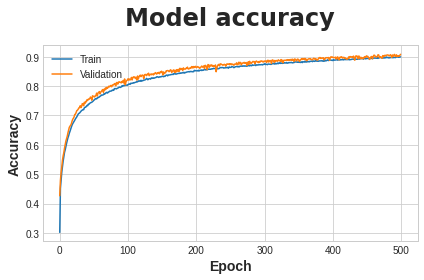

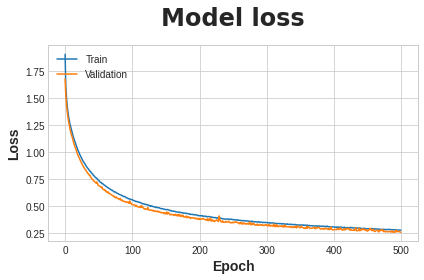

In [ ]:
plt.style.use("seaborn-whitegrid")

# Plot training & validation accuracy values
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy', fontsize=24, fontweight="bold", fontfamily="Georgia", pad=20)
plt.ylabel('Accuracy', fontweight="bold", fontsize=14)
plt.xlabel('Epoch', fontweight="bold", fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig("model_accuracy.png")
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss', fontsize=24, fontweight="bold", fontfamily="Georgia", pad=20)
plt.ylabel('Loss', fontweight="bold", fontsize=14)
plt.xlabel('Epoch', fontweight="bold", fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig("model_loss.png")
plt.show()

In [ ]:
loss, acc = model.evaluate(x_train, y_train)

print(f"Loss: {loss}")
print(f"Accuracy: {acc * 100}%")

41428/41428 [==============================] - 36s 869us/step
Loss: 0.24136354615182573
Accuracy: 91.33918881416321%


In [ ]:
loss, acc = model.evaluate(x_val, y_val)

print(f"Loss: {loss}")
print(f"Accuracy: {acc * 100}%")

17756/17756 [==============================] - 13s 716us/step
Loss: 0.25722995371895346
Accuracy: 90.84253311157227%


In [ ]:
loss, acc = model.evaluate(x_test, y_test_labels)

print(f"Loss: {loss}")
print(f"Accuracy: {acc * 100}%")

6576/6576 [==============================] - 5s 724us/step
Loss: 0.2528849590497223
Accuracy: 91.18005037307739%


# Confusion Matrix (Training)
> CNN-Softmax

In [ ]:
pred_labels = np.argmax(model.predict(x_train), axis=1)

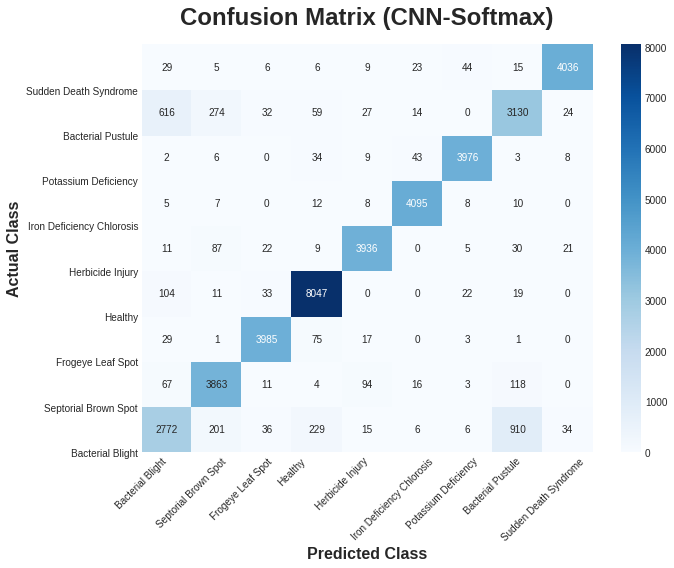

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-Softmax)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.show()

# Confusion Matrix (Testing)
> CNN-Softmax

In [ ]:
pred_labels = np.argmax(model.predict(x_test), axis=1)

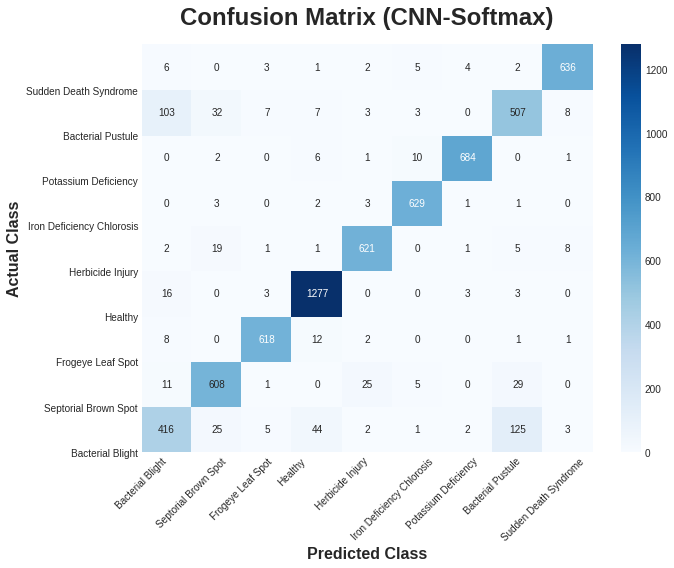

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-Softmax)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.show()

# Classification Reports (Training, Validation, Testing)

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       623
           1       0.88      0.90      0.89       679
           2       0.97      0.96      0.97       642
           3       0.95      0.98      0.96      1302
           4       0.94      0.94      0.94       658
           5       0.96      0.98      0.97       639
           6       0.98      0.97      0.98       704
           7       0.75      0.76      0.76       670
           8       0.97      0.97      0.97       659

    accuracy                           0.91      6576
   macro avg       0.91      0.90      0.90      6576
weighted avg       0.91      0.91      0.91      6576



In [ ]:
pred_labels = np.argmax(model.predict(x_train), axis=1)

report = classification_report(np.argmax(y_train, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      4209
           1       0.87      0.93      0.90      4176
           2       0.97      0.97      0.97      4111
           3       0.95      0.98      0.96      8236
           4       0.96      0.96      0.96      4121
           5       0.98      0.99      0.98      4145
           6       0.98      0.97      0.98      4081
           7       0.74      0.75      0.74      4176
           8       0.98      0.97      0.97      4173

    accuracy                           0.91     41428
   macro avg       0.91      0.91      0.91     41428
weighted avg       0.91      0.91      0.91     41428



In [ ]:
pred_labels = np.argmax(model.predict(x_val), axis=1)

report = classification_report(np.argmax(y_val, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.65      0.70      1744
           1       0.86      0.92      0.89      1721
           2       0.95      0.96      0.96      1823
           3       0.95      0.97      0.96      3614
           4       0.96      0.95      0.96      1797
           5       0.97      0.98      0.98      1792
           6       0.97      0.97      0.97      1791
           7       0.73      0.73      0.73      1730
           8       0.97      0.95      0.96      1744

    accuracy                           0.91     17756
   macro avg       0.90      0.90      0.90     17756
weighted avg       0.91      0.91      0.91     17756



# Training Data Per-class Accuracy

In [ ]:
pred_labels = np.argmax(model.predict(x_train), axis=1)

Bacterial Blight Accuracy: 65.85887384176765 %
Septorial Brown Spot Accuracy: 92.50478927203065 %
Frogeye Leaf Spot Accuracy: 96.93505229871077 %
Healthy Accuracy: 97.70519669742593 %
Herbicide Injury Accuracy: 95.51079834991508 %
Iron Deficiency Chlorosis Accuracy: 98.79372738238843 %
Potassium Deficiency Accuracy: 97.42710120068611 %
Bacterial Pustule Accuracy: 74.9521072796935 %
Sudden Death Syndrome Accuracy: 96.7169901749341 %


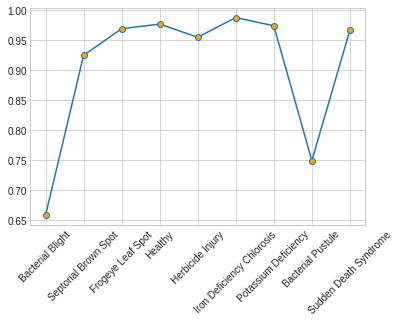

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Validation Data Per-class Accuracy

In [ ]:
pred_labels = np.argmax(model.predict(x_val), axis=1)

Bacterial Blight Accuracy: 65.13761467889908 %
Septorial Brown Spot Accuracy: 91.74898314933179 %
Frogeye Leaf Spot Accuracy: 96.26988480526605 %
Healthy Accuracy: 97.42667404537909 %
Herbicide Injury Accuracy: 95.26989426822482 %
Iron Deficiency Chlorosis Accuracy: 98.38169642857143 %
Potassium Deficiency Accuracy: 97.15242881072027 %
Bacterial Pustule Accuracy: 72.94797687861272 %
Sudden Death Syndrome Accuracy: 95.29816513761467 %


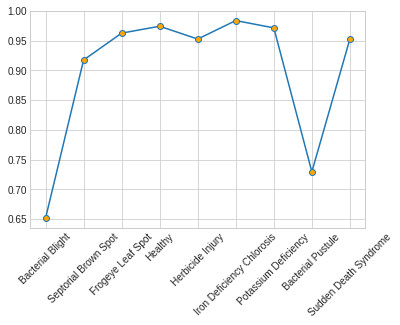

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Test Data Per-class Accuracy

In [ ]:
pred_labels = np.argmax(model.predict(x_test), axis=1) 

Bacterial Blight Accuracy: 66.77367576243981 %
Septorial Brown Spot Accuracy: 89.54344624447718 %
Frogeye Leaf Spot Accuracy: 96.26168224299066 %
Healthy Accuracy: 98.07987711213516 %
Herbicide Injury Accuracy: 94.37689969604864 %
Iron Deficiency Chlorosis Accuracy: 98.43505477308294 %
Potassium Deficiency Accuracy: 97.1590909090909 %
Bacterial Pustule Accuracy: 75.67164179104478 %
Sudden Death Syndrome Accuracy: 96.50986342943855 %


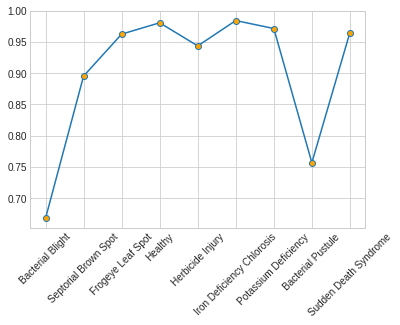

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Load Trained Model

In [ ]:
model_new = Model(inputs=model.input, outputs=model.get_layer("GlobalAveragePooling2D_1").output)

In [ ]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Conv2D_1 (Conv2D)               (None, 64, 64, 8)    32          Input_1[0][0]                    
__________________________________________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)        (None, 64, 64, 8)    0           Conv2D_1[0][0]                   
__________________________________________________________________________________________________
MaxPooling2D_1 (MaxPooling2D)   (None, 64, 64, 3)    0           Input_1[0][0]                    
____________________________________________________________________________________________

# SVM Training
Note: using rbf kernel
> Fit all features acquired from CNN in SVM

In [ ]:
feat_train = model_new.predict(x_train)

feat_val = model_new.predict(x_val)

feat_test = model_new.predict(x_test)

In [ ]:
feat_train_val = np.concatenate((feat_train, feat_val))
y_train_val = np.concatenate((y_train, y_val))

In [ ]:
%%time
svm_rbf = SVC(kernel="rbf", C=1000)

# Train the classifier
svm_rbf.fit(feat_train_val, np.argmax(y_train_val, axis=1))

print("Fitting done!")

Fitting done!
CPU times: user 47.2 s, sys: 4.78 ms, total: 47.2 s
Wall time: 47.2 s


In [ ]:
acc = svm_rbf.score(feat_train_val, np.argmax(y_train_val, axis=1))

print(f"Accuracy: {acc * 100}%")

Accuracy: 99.46607191132738%


In [ ]:
acc = svm_rbf.score(feat_test, np.argmax(y_test_labels, axis=1))

print(f"Accuracy: {acc * 100}%")

Accuracy: 98.14476885644768%


In [ ]:
dump(svm_rbf, f'/content/drive/My Drive/Dataset/svm_rbf_{datetime.now()}')

['/content/drive/My Drive/Dataset/svm_rbf_2020-04-21 17:08:26.741869']

# Confusion Matrix (Training)
> CNN-SVM

In [ ]:
pred_labels = svm_rbf.predict(feat_train)

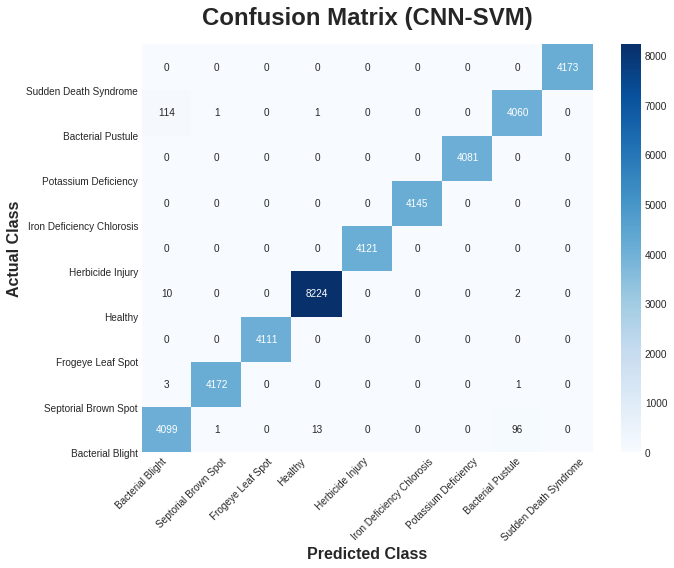

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-SVM)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.show()

# Specificity

In [ ]:
labels_specificity =  {'Bacterial Blight': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 'Septorial Brown Spot': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 
                        'Frogeye Leaf Spot': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 'Healthy': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 'Herbicide Injury': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 
                        'Iron Deficiency Chlorosis': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 'Potassium Deficiency': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 
                        'Bacterial Pustule': {'TP': None, 'TN': None, 'FN': None,'FP': None}, 'Sudden Death Syndrome': {'TP': None, 'TN': None, 'FN': None,'FP': None}}

In [ ]:
i = 0

for key in labels_specificity.keys():
  temp = np.ma.array(conf_matrix, mask=False)
  labels_specificity[key]['TP'] = temp[i, i]
  temp.mask[i, i] = True
  labels_specificity[key]['TN'] = temp[i, :].sum() + temp[:, i].sum()
  labels_specificity[key]['FN'] = temp[i, :].sum()
  labels_specificity[key]['FP'] = temp[:, i].sum()
  i += 1

In [ ]:
specificities = {'Bacterial Blight': None, 'Septorial Brown Spot': None, 'Frogeye Leaf Spot': None, 'Healthy': None, 'Herbicide Injury': None, 'Iron Deficiency Chlorosis': None, 
                 'Potassium Deficiency': None, 'Bacterial Pustule': None, 'Sudden Death Syndrome': None}
sensitivities = {'Bacterial Blight': None, 'Septorial Brown Spot': None, 'Frogeye Leaf Spot': None, 'Healthy': None, 'Herbicide Injury': None, 'Iron Deficiency Chlorosis': None, 
                 'Potassium Deficiency': None, 'Bacterial Pustule': None, 'Sudden Death Syndrome': None}

// SPECIFICITY = TN / (TN + FP)
for key in labels_specificity.keys():
  temp = labels_specificity[key]['TN'] / (labels_specificity[key]['TN'] + labels_specificity[key]['FP'])

  if np.isnan(temp):
    specificities[key] = 1.
  else:
    specificities[key] = temp

// SENSITIVITY = TP / (TP / FN)
for key in labels_specificity.keys():
  temp = labels_specificity[key]['TP'] / (labels_specificity[key]['TP'] + labels_specificity[key]['FN'])

  if np.isnan(temp):
    sensitivities[key] = 1.
  else:
    sensitivities[key] = temp

In [ ]:
specificities

{'Bacterial Blight': 0.6510989010989011,
 'Bacterial Pustule': 0.6847133757961783,
 'Frogeye Leaf Spot': 1.0,
 'Healthy': 0.65,
 'Herbicide Injury': 1.0,
 'Iron Deficiency Chlorosis': 1.0,
 'Potassium Deficiency': 1.0,
 'Septorial Brown Spot': 0.75,
 'Sudden Death Syndrome': 1.0}

In [ ]:
sensitivities

{'Bacterial Blight': 0.9738655262532668,
 'Bacterial Pustule': 0.9722222222222222,
 'Frogeye Leaf Spot': 1.0,
 'Healthy': 0.9985429820301117,
 'Herbicide Injury': 1.0,
 'Iron Deficiency Chlorosis': 1.0,
 'Potassium Deficiency': 1.0,
 'Septorial Brown Spot': 0.9990421455938697,
 'Sudden Death Syndrome': 1.0}

# Confusion Matrix (Testing)
> CNN-SVM

In [ ]:
pred_labels = svm_rbf.predict(feat_test)

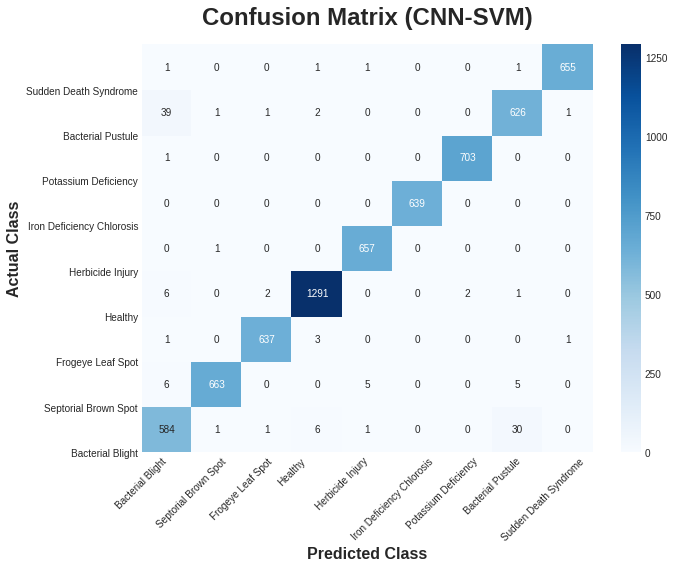

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-SVM)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.show()

# Classification Reports (Training, Validation, Testing)

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       623
           1       1.00      0.98      0.99       679
           2       0.99      0.99      0.99       642
           3       0.99      0.99      0.99      1302
           4       0.99      1.00      0.99       658
           5       1.00      1.00      1.00       639
           6       1.00      1.00      1.00       704
           7       0.94      0.93      0.94       670
           8       1.00      0.99      1.00       659

    accuracy                           0.98      6576
   macro avg       0.98      0.98      0.98      6576
weighted avg       0.98      0.98      0.98      6576



In [ ]:
pred_labels = svm_rbf.predict(feat_train)

report = classification_report(np.argmax(y_train, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4209
           1       1.00      1.00      1.00      4176
           2       1.00      1.00      1.00      4111
           3       1.00      1.00      1.00      8236
           4       1.00      1.00      1.00      4121
           5       1.00      1.00      1.00      4145
           6       1.00      1.00      1.00      4081
           7       0.98      0.97      0.97      4176
           8       1.00      1.00      1.00      4173

    accuracy                           0.99     41428
   macro avg       0.99      0.99      0.99     41428
weighted avg       0.99      0.99      0.99     41428



In [ ]:
pred_labels = svm_rbf.predict(feat_val)

report = classification_report(np.argmax(y_val, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1744
           1       1.00      1.00      1.00      1721
           2       1.00      1.00      1.00      1823
           3       1.00      1.00      1.00      3614
           4       1.00      1.00      1.00      1797
           5       1.00      1.00      1.00      1792
           6       1.00      1.00      1.00      1791
           7       0.98      0.98      0.98      1730
           8       1.00      1.00      1.00      1744

    accuracy                           1.00     17756
   macro avg       1.00      1.00      1.00     17756
weighted avg       1.00      1.00      1.00     17756



# Training Data Per-class Accuracy

In [ ]:
pred_labels = svm_rbf.predict(feat_train)

Bacterial Blight Accuracy: 97.38655262532669 %
Septorial Brown Spot Accuracy: 99.90421455938697 %
Frogeye Leaf Spot Accuracy: 100.0 %
Healthy Accuracy: 99.85429820301117 %
Herbicide Injury Accuracy: 100.0 %
Iron Deficiency Chlorosis Accuracy: 100.0 %
Potassium Deficiency Accuracy: 100.0 %
Bacterial Pustule Accuracy: 97.22222222222221 %
Sudden Death Syndrome Accuracy: 100.0 %


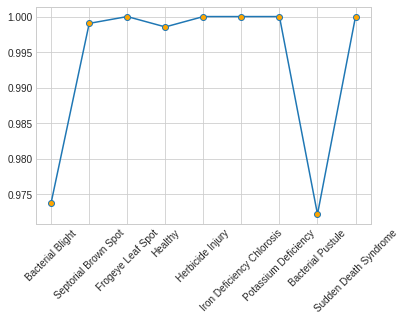

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Validation Data Per-class Acuracy

In [ ]:
pred_labels = svm_rbf.predict(feat_val)

Bacterial Blight Accuracy: 97.64908256880734 %
Septorial Brown Spot Accuracy: 100.0 %
Frogeye Leaf Spot Accuracy: 100.0 %
Healthy Accuracy: 99.86164914222468 %
Herbicide Injury Accuracy: 100.0 %
Iron Deficiency Chlorosis Accuracy: 100.0 %
Potassium Deficiency Accuracy: 100.0 %
Bacterial Pustule Accuracy: 98.38150289017341 %
Sudden Death Syndrome Accuracy: 100.0 %


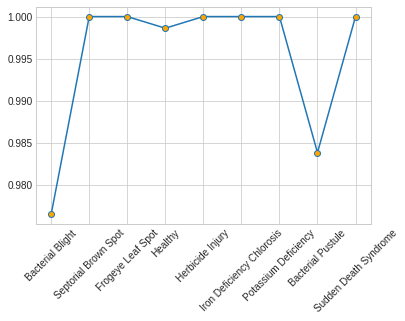

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Test Data Per-class Accuracy

In [ ]:
pred_labels = svm_rbf.predict(feat_test)

Bacterial Blight Accuracy: 93.73996789727127 %
Septorial Brown Spot Accuracy: 97.64359351988217 %
Frogeye Leaf Spot Accuracy: 99.22118380062305 %
Healthy Accuracy: 99.15514592933948 %
Herbicide Injury Accuracy: 99.84802431610942 %
Iron Deficiency Chlorosis Accuracy: 100.0 %
Potassium Deficiency Accuracy: 99.85795454545455 %
Bacterial Pustule Accuracy: 93.43283582089552 %
Sudden Death Syndrome Accuracy: 99.39301972685888 %


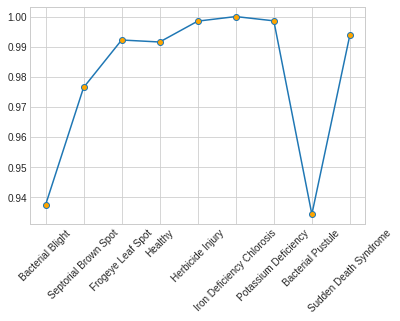

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# SVM Training
Note: using linear kernel
> Fit all features acquired from CNN in SVM

In [ ]:
%%time

svm_linear = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Train the classifier
svm_linear.fit(feat_train_val, np.argmax(y_train_val, axis=1))

print("Fitting done!")

Fitting done!
CPU times: user 954 ms, sys: 438 µs, total: 954 ms
Wall time: 956 ms


In [ ]:
dump(svm_linear_grid, f"./drive/My Drive/Dataset/trained_model_svm_linear_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

['./drive/My Drive/Dataset/trained_model_svm_linear_Sunday-01-19-2020-03-45-30']

In [ ]:
svm_linear.score(feat_train_val, np.argmax(y_train_val, axis=1))

0.9057684509326845

In [ ]:
svm_linear.score(feat_test, np.argmax(y_test_labels, axis=1))

0.9073905109489051

# Confusion Matrix (Training)

In [ ]:
pred_labels = svm_linear.predict(feat_train)

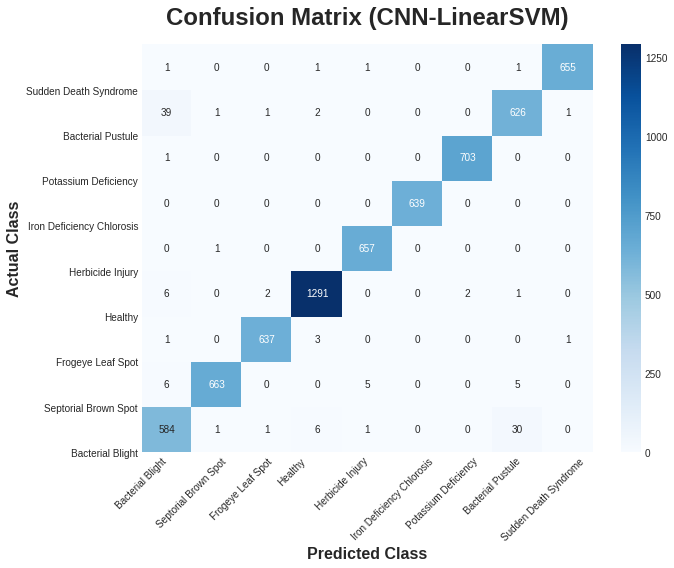

In [ ]:
confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-LinearSVM)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

# Confusion Matrix (Testing)

In [ ]:
pred_labels = svm_linear.predict(feat_test)

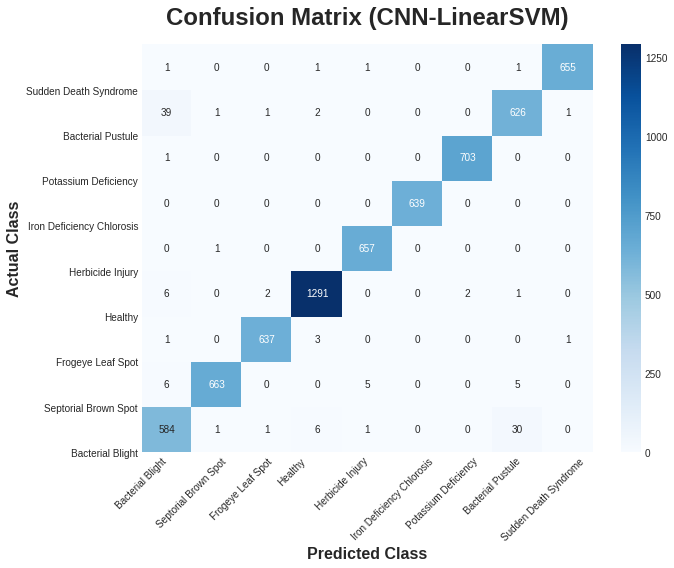

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-LinearSVM)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

# Classification Reports (Training Validation Testing)

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       623
           1       0.89      0.87      0.88       679
           2       0.96      0.96      0.96       642
           3       0.93      0.99      0.96      1302
           4       0.93      0.95      0.94       658
           5       0.96      0.98      0.97       639
           6       0.98      0.97      0.98       704
           7       0.75      0.76      0.76       670
           8       0.94      0.97      0.95       659

    accuracy                           0.91      6576
   macro avg       0.90      0.90      0.90      6576
weighted avg       0.90      0.91      0.90      6576



In [ ]:
pred_labels = svm_linear.predict(feat_train)

report = classification_report(np.argmax(y_train, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.62      0.69      4209
           1       0.86      0.91      0.88      4176
           2       0.96      0.97      0.96      4111
           3       0.93      0.98      0.96      8236
           4       0.95      0.95      0.95      4121
           5       0.97      0.99      0.98      4145
           6       0.97      0.97      0.97      4081
           7       0.74      0.74      0.74      4176
           8       0.96      0.97      0.96      4173

    accuracy                           0.91     41428
   macro avg       0.90      0.90      0.90     41428
weighted avg       0.90      0.91      0.90     41428



In [ ]:
pred_labels = svm_linear.predict(feat_val)

report = classification_report(np.argmax(y_val, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.60      0.67      1744
           1       0.86      0.90      0.88      1721
           2       0.95      0.95      0.95      1823
           3       0.92      0.98      0.95      3614
           4       0.95      0.95      0.95      1797
           5       0.97      0.99      0.98      1792
           6       0.97      0.97      0.97      1791
           7       0.73      0.73      0.73      1730
           8       0.96      0.95      0.96      1744

    accuracy                           0.90     17756
   macro avg       0.90      0.89      0.89     17756
weighted avg       0.90      0.90      0.90     17756



# Training Data Per-class Accuracy

In [ ]:
pred_labels = svm_linear.predict(feat_train)

Bacterial Blight Accuracy: 61.58232359230221 %
Septorial Brown Spot Accuracy: 91.044061302682 %
Frogeye Leaf Spot Accuracy: 96.66747749939188 %
Healthy Accuracy: 98.36085478387567 %
Herbicide Injury Accuracy: 95.38946857558845 %
Iron Deficiency Chlorosis Accuracy: 99.03498190591074 %
Potassium Deficiency Accuracy: 96.7900024503798 %
Bacterial Pustule Accuracy: 73.89846743295018 %
Sudden Death Syndrome Accuracy: 96.78888090103044 %


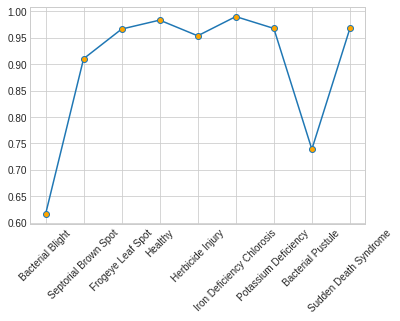

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Validation Data Per-class Acuracy

In [ ]:
pred_labels = svm_linear.predict(feat_val)

Bacterial Blight Accuracy: 59.977064220183486 %
Septorial Brown Spot Accuracy: 89.65717606042998 %
Frogeye Leaf Spot Accuracy: 95.28250137136588 %
Healthy Accuracy: 98.31211953514112 %
Herbicide Injury Accuracy: 95.49248747913188 %
Iron Deficiency Chlorosis Accuracy: 98.99553571428571 %
Potassium Deficiency Accuracy: 96.98492462311557 %
Bacterial Pustule Accuracy: 72.83236994219652 %
Sudden Death Syndrome Accuracy: 95.2408256880734 %


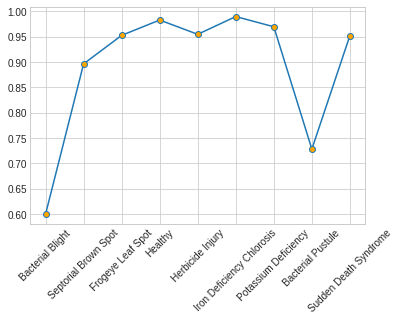

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Test Data Per-class Accuracy

In [ ]:
pred_labels = svm_linear.predict(feat_test)

Bacterial Blight Accuracy: 61.31621187800963 %
Septorial Brown Spot Accuracy: 87.03976435935199 %
Frogeye Leaf Spot Accuracy: 96.10591900311528 %
Healthy Accuracy: 98.84792626728111 %
Herbicide Injury Accuracy: 95.44072948328267 %
Iron Deficiency Chlorosis Accuracy: 98.43505477308294 %
Potassium Deficiency Accuracy: 97.30113636363636 %
Bacterial Pustule Accuracy: 75.82089552238806 %
Sudden Death Syndrome Accuracy: 97.11684370257967 %


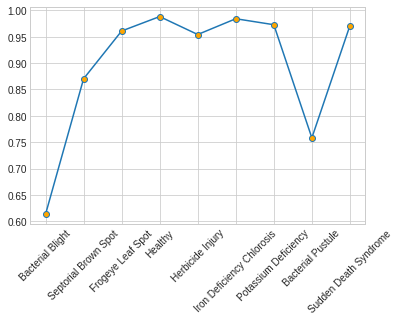

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Random-Forest Training

> Fit all features acquired from CNN in Random-Forest

In [ ]:
%%time
random_forest_classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", n_jobs=-1)

random_forest_classifier.fit(feat_train_val, np.argmax(y_train_val, axis=1))

print("Fitting done!")

Fitting done!
CPU times: user 1min 58s, sys: 13.3 ms, total: 1min 58s
Wall time: 1min


In [ ]:
dump(random_forest_classifier, f"./drive/My Drive/Dataset/trained_model_random_forest_classifier_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

['./drive/My Drive/Dataset/trained_model_random_forest_classifier_Sunday-01-19-2020-03-50-46']

In [ ]:
random_forest_classifier.score(feat_train_val, np.argmax(y_train_val, axis=1))

1.0

In [ ]:
random_forest_classifier.score(feat_test, np.argmax(y_test_labels, axis=1))

0.9708029197080292

# Confusion Matrix (Training)

In [ ]:
pred_labels = random_forest_classifier.predict(feat_train)

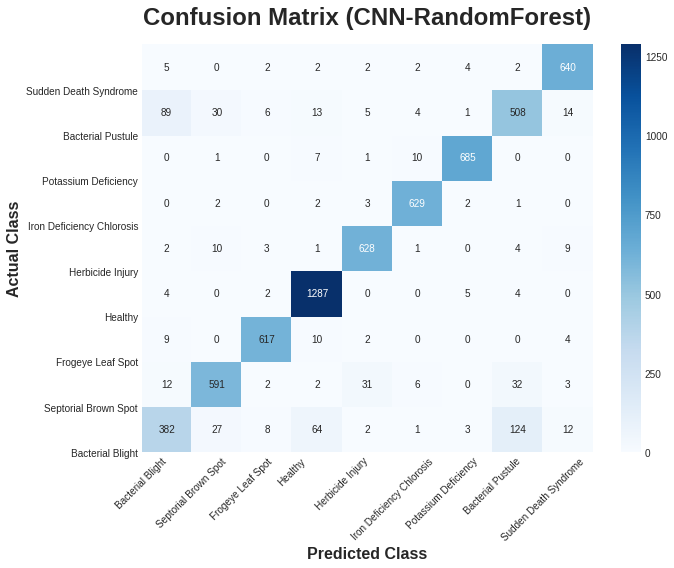

In [ ]:
confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-RandomForest)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

# Confusion Matrix (Testing)

In [ ]:
pred_labels = random_forest_classifier.predict(feat_test)

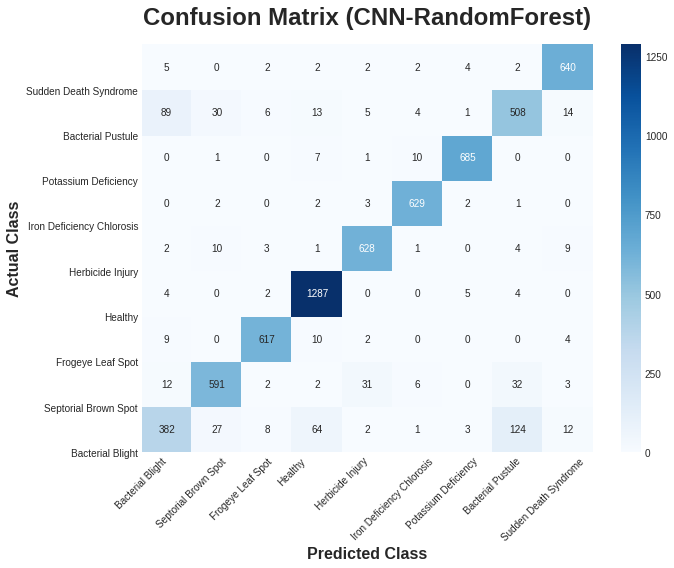

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-RandomForest)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

# Classification Reports (Training Validation Testing)

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       623
           1       0.96      0.97      0.96       679
           2       0.99      0.99      0.99       642
           3       0.98      0.99      0.98      1302
           4       0.99      0.98      0.99       658
           5       0.99      1.00      0.99       639
           6       0.99      0.99      0.99       704
           7       0.92      0.92      0.92       670
           8       0.99      0.99      0.99       659

    accuracy                           0.97      6576
   macro avg       0.97      0.97      0.97      6576
weighted avg       0.97      0.97      0.97      6576



In [ ]:
pred_labels = random_forest_classifier.predict(feat_train)

report = classification_report(np.argmax(y_train, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4209
           1       1.00      1.00      1.00      4176
           2       1.00      1.00      1.00      4111
           3       1.00      1.00      1.00      8236
           4       1.00      1.00      1.00      4121
           5       1.00      1.00      1.00      4145
           6       1.00      1.00      1.00      4081
           7       1.00      1.00      1.00      4176
           8       1.00      1.00      1.00      4173

    accuracy                           1.00     41428
   macro avg       1.00      1.00      1.00     41428
weighted avg       1.00      1.00      1.00     41428



In [ ]:
pred_labels = random_forest_classifier.predict(feat_val)

report = classification_report(np.argmax(y_val, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1744
           1       1.00      1.00      1.00      1721
           2       1.00      1.00      1.00      1823
           3       1.00      1.00      1.00      3614
           4       1.00      1.00      1.00      1797
           5       1.00      1.00      1.00      1792
           6       1.00      1.00      1.00      1791
           7       1.00      1.00      1.00      1730
           8       1.00      1.00      1.00      1744

    accuracy                           1.00     17756
   macro avg       1.00      1.00      1.00     17756
weighted avg       1.00      1.00      1.00     17756



# Training Data Per-class Accuracy

In [ ]:
pred_labels = random_forest_classifier.predict(feat_train)

Bacterial Blight Accuracy: 100.0 %
Septorial Brown Spot Accuracy: 100.0 %
Frogeye Leaf Spot Accuracy: 100.0 %
Healthy Accuracy: 100.0 %
Herbicide Injury Accuracy: 100.0 %
Iron Deficiency Chlorosis Accuracy: 100.0 %
Potassium Deficiency Accuracy: 100.0 %
Bacterial Pustule Accuracy: 100.0 %
Sudden Death Syndrome Accuracy: 100.0 %


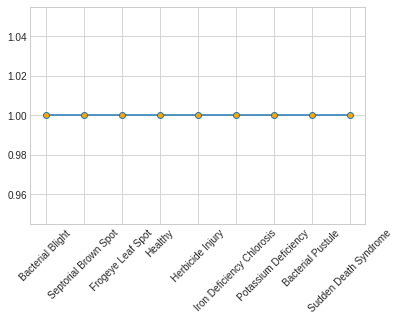

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Validation Data Per-class Acuracy

In [ ]:
pred_labels = random_forest_classifier.predict(feat_val)

Bacterial Blight Accuracy: 100.0 %
Septorial Brown Spot Accuracy: 100.0 %
Frogeye Leaf Spot Accuracy: 100.0 %
Healthy Accuracy: 100.0 %
Herbicide Injury Accuracy: 100.0 %
Iron Deficiency Chlorosis Accuracy: 100.0 %
Potassium Deficiency Accuracy: 100.0 %
Bacterial Pustule Accuracy: 100.0 %
Sudden Death Syndrome Accuracy: 100.0 %


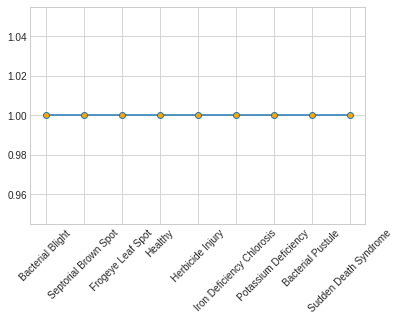

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Test Data Per-class Accuracy

In [ ]:
pred_labels = random_forest_classifier.predict(feat_test)

Bacterial Blight Accuracy: 87.80096308186197 %
Septorial Brown Spot Accuracy: 96.90721649484536 %
Frogeye Leaf Spot Accuracy: 98.75389408099689 %
Healthy Accuracy: 99.0015360983103 %
Herbicide Injury Accuracy: 98.48024316109422 %
Iron Deficiency Chlorosis Accuracy: 99.53051643192488 %
Potassium Deficiency Accuracy: 99.43181818181817 %
Bacterial Pustule Accuracy: 92.23880597014926 %
Sudden Death Syndrome Accuracy: 99.2412746585736 %


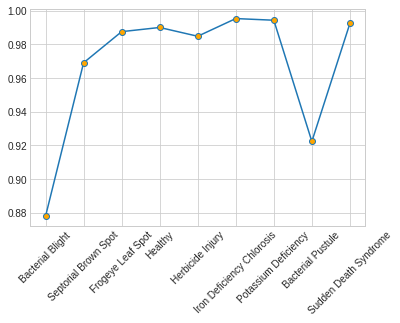

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# XGBoost Training

> Fit all features acquired from CNN in XGBoost

In [ ]:
%%time
xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=300,
                    objective="multi:softmax",
                    num_class=9,
                    n_jobs=-1)

eval_set = [(feat_test, np.argmax(y_test_labels, axis=1))]

xgb.fit(feat_train_val, np.argmax(y_train_val, axis=1), eval_metric="merror", 
        eval_set=eval_set, verbose=True)

print("Fitting done!")

[0]	validation_0-merror:0.176399
[1]	validation_0-merror:0.175335
[2]	validation_0-merror:0.170773
[3]	validation_0-merror:0.164538
[4]	validation_0-merror:0.163473
[5]	validation_0-merror:0.160584
[6]	validation_0-merror:0.161192
[7]	validation_0-merror:0.160888
[8]	validation_0-merror:0.161192
[9]	validation_0-merror:0.161344
[10]	validation_0-merror:0.161496
[11]	validation_0-merror:0.161953
[12]	validation_0-merror:0.161344
[13]	validation_0-merror:0.16028
[14]	validation_0-merror:0.16028
[15]	validation_0-merror:0.16028
[16]	validation_0-merror:0.160736
[17]	validation_0-merror:0.160432
[18]	validation_0-merror:0.16028
[19]	validation_0-merror:0.158151
[20]	validation_0-merror:0.159063
[21]	validation_0-merror:0.159215
[22]	validation_0-merror:0.158455
[23]	validation_0-merror:0.158607
[24]	validation_0-merror:0.157238
[25]	validation_0-merror:0.156934
[26]	validation_0-merror:0.156174
[27]	validation_0-merror:0.156174
[28]	validation_0-merror:0.155718
[29]	validation_0-merror:0.1

In [ ]:
dump(xgb, f"./drive/My Drive/Dataset/xgb_{datetime.now().strftime('%A-%m-%d-%Y-%H-%M-%S')}")

['./drive/My Drive/Dataset/xgb_Sunday-01-19-2020-04-02-59']

In [ ]:
xgb.score(feat_train_val, np.argmax(y_train_val, axis=1))

0.8991281427412814

In [ ]:
xgb.score(feat_test, np.argmax(y_test_labels, axis=1))

0.8927919708029197

# Confusion Matrix (Training)

In [ ]:
pred_labels = xgb.predict(feat_train)

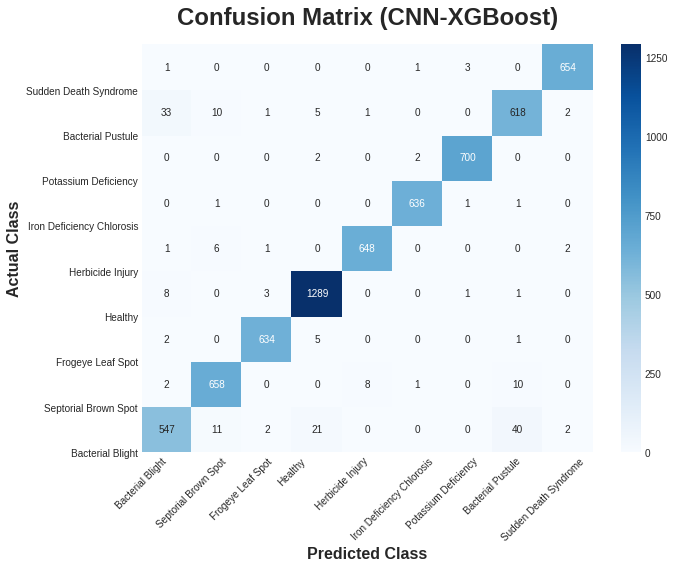

In [ ]:
confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-XGBoost)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

# Confusion Matrix (Testing)

In [ ]:
pred_labels = xgb.predict(feat_test)

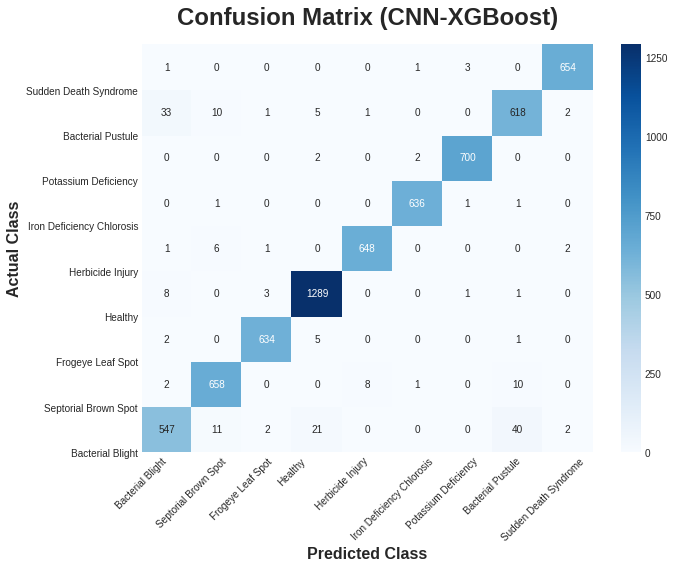

In [ ]:
confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
ax.invert_yaxis()
plt.title("Confusion Matrix (CNN-XGBoost)", pad=20, fontsize=24, fontweight="bold")
plt.xlabel("Predicted Class", fontsize=16, fontweight="bold")
plt.ylabel("Actual Class", fontsize=16, fontweight="bold")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.yticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation="horizontal")
plt.tight_layout()
plt.savefig("model_confusion_matrix_2.png")
plt.show()

# Classification Reports (Training Validation Testing)

In [ ]:
report = classification_report(np.argmax(y_test_labels, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       623
           1       0.88      0.88      0.88       679
           2       0.95      0.94      0.95       642
           3       0.93      0.97      0.95      1302
           4       0.94      0.93      0.93       658
           5       0.96      0.98      0.97       639
           6       0.97      0.97      0.97       704
           7       0.69      0.75      0.72       670
           8       0.96      0.95      0.96       659

    accuracy                           0.89      6576
   macro avg       0.89      0.88      0.88      6576
weighted avg       0.89      0.89      0.89      6576



In [ ]:
pred_labels = xgb.predict(feat_train)

report = classification_report(np.argmax(y_train, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.60      0.65      4209
           1       0.86      0.91      0.89      4176
           2       0.96      0.94      0.95      4111
           3       0.94      0.98      0.96      8236
           4       0.96      0.94      0.95      4121
           5       0.97      0.99      0.98      4145
           6       0.97      0.97      0.97      4081
           7       0.69      0.73      0.71      4176
           8       0.97      0.96      0.96      4173

    accuracy                           0.90     41428
   macro avg       0.89      0.89      0.89     41428
weighted avg       0.90      0.90      0.90     41428



In [ ]:
pred_labels = xgb.predict(feat_val)

report = classification_report(np.argmax(y_val, axis=1), pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.61      0.66      1744
           1       0.85      0.90      0.88      1721
           2       0.95      0.94      0.95      1823
           3       0.94      0.97      0.96      3614
           4       0.96      0.94      0.95      1797
           5       0.97      0.98      0.97      1792
           6       0.97      0.97      0.97      1791
           7       0.71      0.73      0.72      1730
           8       0.96      0.96      0.96      1744

    accuracy                           0.90     17756
   macro avg       0.89      0.89      0.89     17756
weighted avg       0.90      0.90      0.90     17756



# Training Data Per-class Accuracy

In [ ]:
pred_labels = xgb.predict(feat_train)

Bacterial Blight Accuracy: 59.9192207175101 %
Septorial Brown Spot Accuracy: 91.28352490421456 %
Frogeye Leaf Spot Accuracy: 93.89442957917782 %
Healthy Accuracy: 97.83875667799903 %
Herbicide Injury Accuracy: 94.24896869691823 %
Iron Deficiency Chlorosis Accuracy: 98.5524728588661 %
Potassium Deficiency Accuracy: 96.691987258025 %
Bacterial Pustule Accuracy: 73.25191570881226 %
Sudden Death Syndrome Accuracy: 96.26168224299066 %


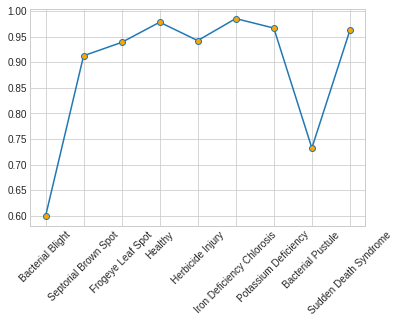

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Validation Data Per-class Acuracy

In [ ]:
pred_labels = xgb.predict(feat_val)

Bacterial Blight Accuracy: 61.18119266055045 %
Septorial Brown Spot Accuracy: 90.29633933759442 %
Frogeye Leaf Spot Accuracy: 94.45968184311575 %
Healthy Accuracy: 97.23298284449363 %
Herbicide Injury Accuracy: 94.32387312186978 %
Iron Deficiency Chlorosis Accuracy: 98.15848214285714 %
Potassium Deficiency Accuracy: 97.04075935231714 %
Bacterial Pustule Accuracy: 72.60115606936417 %
Sudden Death Syndrome Accuracy: 95.52752293577981 %


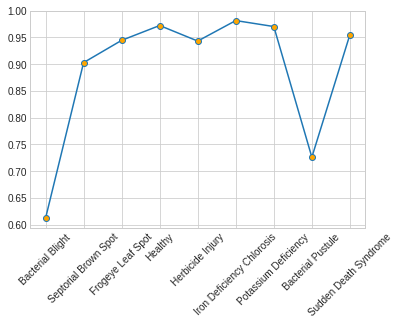

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Test Data Per-class Accuracy

In [ ]:
pred_labels = xgb.predict(feat_test)

Bacterial Blight Accuracy: 57.9454253611557 %
Septorial Brown Spot Accuracy: 87.77614138438881 %
Frogeye Leaf Spot Accuracy: 94.39252336448598 %
Healthy Accuracy: 96.7741935483871 %
Herbicide Injury Accuracy: 92.5531914893617 %
Iron Deficiency Chlorosis Accuracy: 98.27856025039124 %
Potassium Deficiency Accuracy: 96.875 %
Bacterial Pustule Accuracy: 74.77611940298507 %
Sudden Death Syndrome Accuracy: 95.2959028831563 %


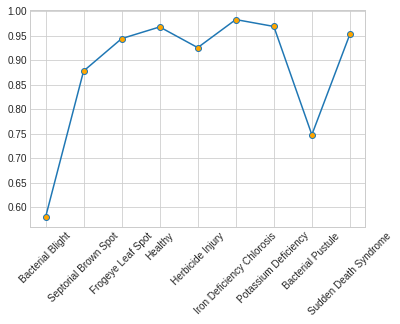

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_labels)
acc_per_class = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
classes = ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome']

for index, x in enumerate(acc_per_class):
  print(f"{classes[index]} Accuracy: {x * 100} %")

plt.plot([i for i in range(0, 9, 1)], acc_per_class, marker='o', markerfacecolor="orange")
plt.xticks([i for i in range(0, 9, 1)], ['Bacterial Blight', 'Septorial Brown Spot', 
                                         'Frogeye Leaf Spot', 'Healthy', 'Herbicide Injury', 
                                         'Iron Deficiency Chlorosis', 'Potassium Deficiency', 
                                         'Bacterial Pustule', 'Sudden Death Syndrome'], rotation=45)
plt.show()

# Not Included

In [ ]:
import cv2
images = []

for i in range(0, 9, 1):
  images.append(cv2.imread(f"DATASET/Training Samples/{i}/" + os.listdir(f"DATASET/Training Samples/{i}")[0]))
  
np_images = np.array(images)

images2 = []

for i in range(0, 9, 1):
  images2.append(cv2.imread(f"DATASET/Training Samples/{i}/" + os.listdir(f"DATASET/Training Samples/{i}")[300]))
  
np_images2 = np.array(images2)

images3 = []

for i in range(0, 9, 1):
  images3.append(cv2.imread(f"DATASET/Training Samples/{i}/" + os.listdir(f"DATASET/Training Samples/{i}")[400]))
  
np_images3 = np.array(images3)

In [ ]:
np_images_final = []
np_images_final.extend(np_images)
np_images_final.extend(np_images2)
np_images_final.extend(np_images3)

pred_arr = []

for i in range(27):
  test_pred_img = np_images_final[i]
  test_image = np.expand_dims(test_pred_img, axis=0)
  prediction = model.predict(test_image)
  pred_arr.append(prediction)

plt.figure(figsize=(15, 10))
for i in range(27):
  plt.subplot(3, 9, i + 1)
  plt.title(classes[np.argmax(pred_arr[i], axis=1)[0]], rotation=45)
  plt.imshow(np_images_final[i])
  plt.show